In [ ]:
import os, warnings
from pynq import PL, Overlay
from pynq import allocate
import numpy as np
from time import sleep
from pynq import DefaultIP
import logging

log = logging.getLogger("CZT_Driver")
_command_valids = [0xE0,0xE1,0xE2,0xE3,0xE4,0xE5,0xE6,0xE7,0xE8,0xE9,0x9D,0x9E,0x86,0xA3,0x96,0x9A,0x02,0x85,0x05,0x8C,0x21,0xA1,0x1F,0x9F,0x20,0xA0,0x81,0x01,0x32,0xB2,0x34,0xB4,0x07,0x87,0x0B,0x8B,0x03,0x83,0x84,0x04,0xCB,0x10,0x90,0x48,0xC8,0x4A,0xCA]
_command_has_reply = [0xE0,0x9D,0x9E,0x86,0xA3,0x96,0x9A,0xA1,0x9F,0xA0,0xB2,0xB4,0x87,0x8B,0xC8,0x83,0x84,0xCB]
_command_has_data = [0x21,0x1F,0x20,0x32,0x07,0x0B,0x48,0x03,0x04]
_command_map = {"READ_PART_BASE": 0xE0,
                    "READ_SERIAL_LSB": 0x9D,
                    "READ_SERIAL_MSB": 0x9E,
                    "READ_FIRMWARE_VERSION": 0x86,
                    "READ_MODULE_VERSION": 0xA3,
                    "READ_STATUS": 0x96,
                    "READ_TEMPERATURE": 0x9A,
                    "BREAK": 0x02,
                    "EVENT_ON": 0x85,
                    "EVENT_OFF": 0x05,
                    "FIFO_CLEAR": 0x8C,
                    "SET_THRESHOLD": 0x21,
                    "GET_THRESHOLD": 0xA1,
                    "SET_GPIO": 0x1F,
                    "GET_GPIO": 0x9F,
                    "SET_CLOCK": 0x20,
                    "GET_CLOCK": 0xA0,
                    "RESTORE_SETUP": 0x81,
                    "UPDATE_SETUP": 0x01,
                    "SET_PEAKING_TIME": 0x32,
                    "GET_PEAKING_TIME": 0xB2,
                    "RUN_SELF_TEST": 0x34,
                    "GET_SELF_TEST_RESULTS": 0xB4,
                    "SET_CHANNEL": 0x07,
                    "GET_CHANNEL": 0x87,
                    "CHANNEL_CONTROL": 0x0B,
                    "CHANNEL_STATUS": 0x8B,
                    "SET_ADDR_POINTER": 0x03,
                    "GET_ADDR_POINTER": 0x83,
                    "READ_RAM": 0x84,
                    "WRITE_RAM": 0x04,
                    "EEPROM_CHECKSUM": 0xCB,
                    "HOLD_ON": 0x10,
                    "HOLD_OFF": 0x90,
                    "SET_EMULATOR": 0x48,
                    "GET_EMULATOR": 0xC8,
                    "WRITE_PROTECT_OFF": 0x4A,
                    "WRITE_PROTECT_ON": 0xCA
                   }
    
class CZTDriver(DefaultIP):
    """Class for interacting with the AXI CZT Controller version 1.
    
    Revision: 1.0.24
    
    This class provides driver support for "user.org:user:AXI_CZT_Controller:1.0".
    
    The driver has various functions and properties to abstract away the
    funtionality of the register as well as providing translation between
    command names and actual command op codes.
    
    The driver also wraps an MMIO device for direct access to the underlying
    registers with "read(addr)" and "write(addr,data)" functions.
    """

    def __init__(self, description):
        super().__init__(description=description)
        self.is_channel_disabled = [0]*256
        self.disabled_channel_list = []
        self.num_disabled = 0
    
    bindto = ['user.org:user:AXI_CZT_Controller:1.0']
    
    def command(self, com, inp = None, timeout = 5000):
        # Bring down command valid in anticipation of new command
        self.write(0x0,0x0000)
        
        # Check if command is valid
        if type(com) is str:
            if com in _command_map:
                com = _command_map[com]
            else:
                raise ValueError("Invalid Command String")
        if com not in _command_valids:
            raise ValueError("Invalid Command Number")
        
        # If command needs to send data then,
        #   verify data input is given
        #   send the command along with data and block for acknoledgement
        if (com in _command_has_data):
            if (inp == None):
                raise ValueError(f"Input needed for 0x{com:02x}")
            else:
                # Implement command with data
                packed_command = com | 1<<8 | inp<<16
                self.write(0x0, packed_command)
                rd = self.read(0x4)
                while((not(rd and 0x1)) and timeout!=0):
                    rd = self.read(0x4)
                    timeout -= 1
                if timeout == 0:
                    return -1
                return None
        
        # If command does not have data then just send the command
        packed_command = com | 1<<8 | 0xffff0000
        self.write(0x00, packed_command)
        
        # Wait for acknoledgement of successful command transmission
        rd = self.read(0x04)
        while((not(rd and 0x0001)) and timeout!=0):
            rd = self.read(0x04)
            timeout -= 1
        if timeout == 0:
            return -1
        
        # If command has reply additionally wait for data acknoledgement
        if (com in _command_has_reply):
            while((not(rd and 0x100)) and timeout!=0):
                rd = self.read(0x4)
                timeout -= 1
            if timeout == 0:
                return -1
            return (rd>>16)&0xffff
        else:
            return None
        
    def read_serial(self):
        msb = self.command("READ_SERIAL_MSB")
        lsb = self.command("READ_SERIAL_LSB")
        if (msb==-1) or (lsb==-1):
            return -1
        return (msb<<16|lsb)
    
    def read_channel_status(self, channel):
        if channel > 255:
            raise ValueError("Channel should be between 0 and 255")
        err = self.command("SET_CHANNEL", channel)
        if err == -1:
            return -1
        return self.command("CHANNEL_STATUS")
    
    def disable_channel(self, channel):
        if channel > 255:
            raise ValueError("Channel should be between 0 and 255")
        err = self.command("SET_CHANNEL", channel)
        if err == -1:
            return -1
        err = self.command("CHANNEL_CONTROL", 1)
        if err == -1:
            return -1

    def enable_channel(self, channel):
        if channel > 255:
            raise ValueError("Channel should be between 0 and 255")
        err = self.command("SET_CHANNEL", channel)
        if err == -1:
            return -1
        err = self.command("CHANNEL_CONTROL", 0)
        if err == -1:
            return -1

    def scan_all_channels(self):
        self.disabled_channel_list = []
        self.num_disabled = 0
        for i in range(256):
            self.is_channel_disabled[i] = self.read_channel_status(i)
            if(self.is_channel_disabled[i]==1):
                self.disabled_channel_list.append(i)
                self.num_disabled += 1
    
    def set_clock(self, clk):
        clk = int(clk/5)
        return self.command("SET_CLOCK", clk)
    
    def get_clock(self):
        clk = self.command("GET_CLOCK")
        if clk == -1:
            return -1
        else:
            return clk*5
        
    def set_threshold(self, threshold):
        threshold = int(threshold*1023.0/200.0)
        return self.command("SET_THRESHOLD", threshold)
    
    def get_threshold(self):
        threshold = self.command("GET_THRESHOLD")
        if threshold == -1:
            return -1
        else:
            return threshold*200.0/1023.0
    
    def get_temperature(self):
        temperature = self.command("GET_TEMPERATURE")
        if temperature == -1:
            return -1
        else:
            return temperature
        

        
def parse_event_data(event_data):
    parsed_event_data = []
    for event in event_data:
        timestamp = (event & 0xffffffff00000000) >> 32
        det_id = (event & 0x00000000ff000000) >> 24
        pix_id = (event & 0x0000000000ff0000) >> 16
        energy = (event & 0x000000000000ffff) >> 0
        parsed_event_data.append((timestamp, det_id, pix_id, energy))
    return parsed_event_data

ov = Overlay("./overlays/test_2det_commanding.bit")
czt1 = ov.AXI_CZT_AXIS_0.AXI_CZT_Controller
czt0 = ov.AXI_CZT_AXIS_1.AXI_CZT_Controller
reset_pl = ov.Reset_system.reset_gpio.channel1[0].on
dma_channel = ov.DMA.axi_dma_0.recvchannel
wr_data_count = ov.AXIS_Combine.axi_gpio_0.channel1.read
rd_data_count = ov.AXIS_Combine.axi_gpio_0.channel2.read
print(czt0.read_serial(), czt1.read_serial())
czt1.command("BREAK")
czt0.command("BREAK")
reset_pl()
test_reply_commands = ['READ_SERIAL_LSB',
             'READ_SERIAL_MSB',
             'READ_FIRMWARE_VERSION',
             'READ_MODULE_VERSION',
             'EEPROM_CHECKSUM',
             'GET_CLOCK',
             'GET_EMULATOR',
             'GET_GPIO',
             'GET_PEAKING_TIME',
             'GET_THRESHOLD',
             'READ_STATUS',
             'READ_TEMPERATURE']
print("Command                    CZT 0  CZT 1")
for comm in test_reply_commands:
    print(f"{comm:.<25}{czt0.command(comm):>7}{czt1.command(comm):>7}")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
czt1.command("EVENT_ON")
czt0.command("EVENT_ON")
print(dma_channel.idle)
print(wr_data_count(), rd_data_count())

czt0.command("EVENT_OFF")
czt1.command("EVENT_OFF")

## Take simultaneous data for STC 2 boards
FYI, One packet is 128 events.

In [ ]:
event_data_buffer = allocate(shape=(128,), dtype=np.uint64)
main_buffer = []
#reset_pl()
print(len(main_buffer))

## Do a Continuous acquisition from two detectors at once into the FPGA's DMA buffer

Make sure that the HV is turned ON before you run this cell.

In [195]:
npackets = 2 #0.6s data
dma_channel.start()
czt0.command("EVENT_ON")
czt1.command("EVENT_ON")

for i in range(npackets):
    dma_channel.wait()
    main_buffer.extend(event_data_buffer.tolist())
    dma_channel.transfer(event_data_buffer)

czt1.command("EVENT_OFF")
czt0.command("EVENT_OFF")

## Get 1000 Compton counts according to the geometry and the detector background rates and chance coincidence probabilities.
1) Chance coincidence probabilities is calculated assuming the background is uniform in time and binning is done according to 7.5us.

2) Compton counts probabilities is harder to estimate, we avoid the energy uncertainities and a small fraction of double events happening for two detectors.

In [ ]:
npackets = 1041666 #0.6s data
dma_channel.start()
czt0.command("EVENT_ON")
czt1.command("EVENT_ON")

for i in range(npackets):
    dma_channel.wait()
    main_buffer.extend(event_data_buffer.tolist())
    dma_channel.transfer(event_data_buffer)

czt1.command("EVENT_OFF")
czt0.command("EVENT_OFF")

In [ ]:
czt1.command("BREAK")
czt0.command("BREAK")

In [145]:
parse_main_buffer = parse_event_data(main_buffer)
det0 = []
det1 = []
for x in parse_main_buffer:
    if x[1]== 1:
        det1.append(x)
    elif x[1]== 0:
        det0.append(x)

times_det0 = [x[0] for x in det0]
pixels_det0 = [x[2] for x in det0]
energy_det0 = [x[3] for x in det0]

times_det1 = [x[0] for x in det1]
pixels_det1 = [x[2] for x in det1]
energy_det1 = [x[3] for x in det1]

Number of pixels that gave data: 256
Number of disabled pixels: 0


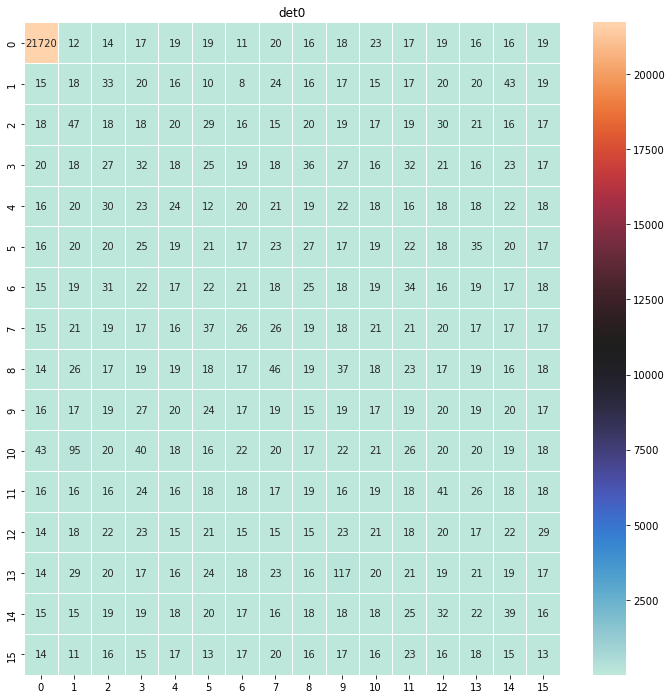

In [146]:
pixhist = np.bincount(pixels_det0, minlength=256)
plt.figure(figsize=(12,12))
plt.title('det0')
sns.heatmap(pixhist.reshape((16,16)), cmap="icefire", linewidths=1, annot= True, fmt=".0f")
print(f"Number of pixels that gave data: {len(np.unique(pixels_det0))}\nNumber of disabled pixels: {czt0.num_disabled}")

Number of pixels that gave data: 253
Number of disabled pixels: 0


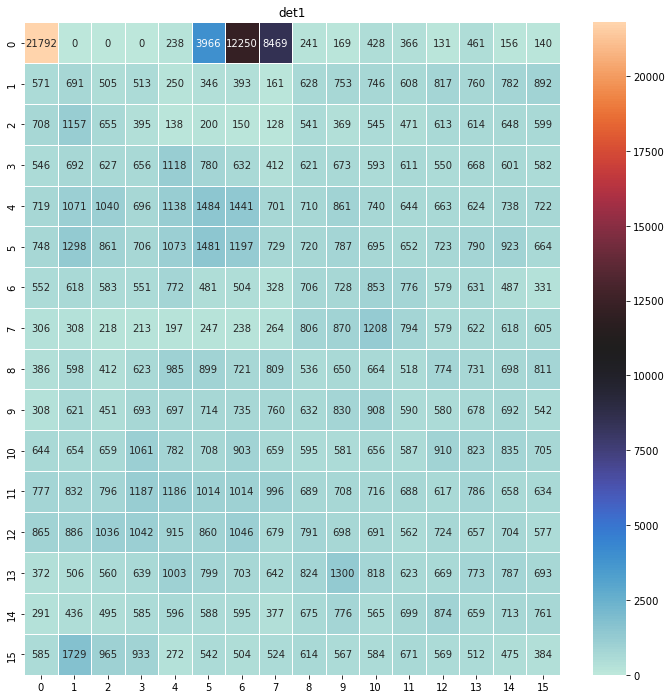

In [147]:
pixhist = np.bincount(pixels_det1, minlength=256)
plt.figure(figsize=(12,12))
plt.title('det1')
sns.heatmap(pixhist.reshape((16,16)), cmap="icefire", linewidths=1, annot= True, fmt=".0f")
print(f"Number of pixels that gave data: {len(np.unique(pixels_det1))}\nNumber of disabled pixels: {czt1.num_disabled}")

In [78]:
len(times_det0)

288

In [79]:
len(times_det1)

224

In [80]:
times_det0

[54209929,
 54209994,
 54210059,
 54210124,
 54210189,
 54210254,
 54210319,
 54210384,
 54210449,
 54210514,
 54210579,
 54210644,
 54210709,
 54210774,
 54210839,
 54210904,
 54210969,
 54211034,
 54211099,
 54211164,
 54211229,
 54211294,
 54211359,
 54211424,
 54211489,
 54211554,
 54211619,
 54211684,
 54211749,
 54211814,
 54211879,
 54211944,
 54212009,
 54212074,
 54212139,
 54212204,
 54212269,
 54212334,
 54212399,
 54212464,
 54212529,
 54212594,
 54212659,
 54212724,
 54212789,
 54212854,
 54212919,
 54212984,
 54213049,
 54213114,
 54213179,
 54213244,
 54213309,
 54213374,
 54213439,
 54213504,
 54213569,
 54213634,
 54213699,
 54213764,
 54213829,
 54213894,
 54213959,
 54214024,
 54214089,
 54214154,
 54214219,
 54214284,
 54214349,
 54214414,
 54214479,
 54214544,
 54215569,
 54215950,
 54216329,
 54216394,
 54216459,
 54216524,
 54216709,
 54216774,
 54216839,
 54216904,
 54217089,
 54217154,
 54217219,
 54217284,
 54217469,
 54217534,
 54217599,
 54217664,
 54217849,

In [94]:
times_det1

[54209926,
 54209953,
 54209980,
 54210007,
 54210034,
 54210061,
 54210088,
 54210115,
 54210142,
 54210169,
 54210196,
 54210223,
 54210250,
 54210277,
 54210304,
 54210331,
 54210358,
 54210385,
 54210412,
 54210439,
 54210466,
 54210493,
 54210520,
 54210547,
 54210574,
 54210601,
 54210628,
 54210655,
 54210682,
 54210709,
 54210736,
 54210763,
 54210790,
 54210817,
 54210844,
 54210871,
 54210898,
 54210925,
 54210952,
 54210979,
 54211006,
 54211033,
 54211060,
 54211087,
 54211114,
 54211141,
 54211168,
 54211195,
 54211222,
 54211249,
 54211276,
 54211303,
 54211330,
 54211357,
 54211384,
 54211411,
 54211438,
 54211465,
 54217112,
 54217491,
 54217872,
 54219013,
 54219394,
 54219773,
 54220146,
 54220533,
 54220914,
 54221293,
 54221674,
 54222053,
 54222434,
 54222797,
 54223194,
 54223563,
 54223944,
 54224331,
 54224696,
 54229957,
 54230050,
 54230099,
 54230142,
 54230185,
 54230236,
 54230285,
 54230336,
 54230385,
 54230436,
 54230485,
 54230534,
 54230577,
 54230626,

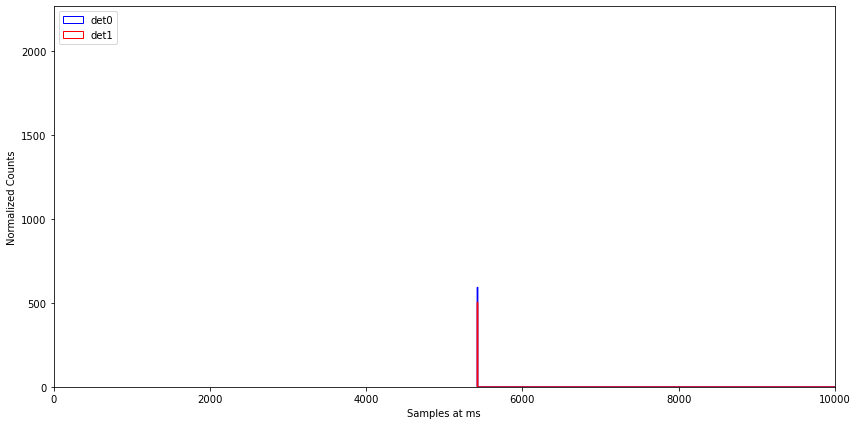

In [93]:
# Light curve / exposure curve
timestamps_det0 = np.array(times_det0)/10000
timestamps_det1 = np.array(times_det1)/10000
binwidth = 10
plt.figure(figsize=(14,7))
plt.hist(timestamps_det0, bins=range(int(min(timestamps_det0)), int(max(timestamps_det0)) + binwidth, binwidth)
         ,histtype='step',alpha = 1, color= 'b', label = 'det0')
         #, density=True)
plt.hist(timestamps_det1, bins=range(int(min(timestamps_det1)), int(max(timestamps_det1)) + binwidth, binwidth)
         ,histtype='step',alpha = 1, color= 'r', label = 'det1')
         #, density=True)

plt.xlabel("Samples at ms")
#plt.yticks([])
plt.xlim(0,10000)
plt.ylabel("Normalized Counts")
plt.legend()
plt.show()

#EpMS_det0 = len(timestamps_det0)/timestamps_det0[len(timestamps_det0)-1]
#EpMS_det1 = len(timestamps_det1)/timestamps_det1[len(timestamps_det1)-1]
#print(f"Event rate in det0 cps = {EpMS_det0*10000:.2f}")
#print(f"Event rate in det1 cps = {EpMS_det1*10000:.2f}")

In [ ]:
plt.figure(figsize=(14,7))
plt.hist(energy_det0, bins=range(0,4096,10),alpha = 0.5, color= 'b', label = 'det0', density=True)
plt.hist(energy_det1, bins=range(0,4096,10), alpha = 0.5, color= 'r', label = 'det1', density=True)
plt.legend()
plt.yticks([])
plt.xlabel("PHA")
plt.ylabel("Normalized Counts")
plt.show()

In [86]:
czt0.command("EVENT_OFF")
czt1.command("EVENT_OFF")

-1

In [160]:
with open("2dets_bkg_iitb_20230609_stcreport.txt", "w") as file:
    file.write(str(main_buffer))

In [ ]:
with open("2dets_bkg2_iitb_20230609_stcreport.txt", "w") as file:
    file.write(main_buffer)